# Here preprocessing (log-transform, median correction) is done

NOTE: Minmax scaling (as this integrates feature information of all samples) must only be fitted on the training set

In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sys.path.append("../")
import AtlasAnalysisFunctions as AAF

In [16]:
nsaf = pd.read_hdf("../../Atlas_creation/proteome_nsaf_pooled_3.h5")
nsaf = nsaf.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")

meta = pd.read_csv("../../Metadata/unified_metadata.csv", index_col="assay_id")

# Drop low identification rate samples (see Abundance_correction.ipynb for reasoning)
low_id_rate = nsaf.loc[meta[meta.PXD_accession.isin("PXD002842 PXD003407 PXD003406 PXD002057 PXD009149 PXD005045 PXD009442 PXD003530 PXD004452".split())].index,:].notna().sum(axis=1)
drop_assays = low_id_rate.index[low_id_rate < 1100]
nsaf = nsaf.loc[~nsaf.index.isin(drop_assays)]

meta = meta[meta.index.isin(nsaf.index)]
groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])

# Only select groups with >= 10 samples
apc = meta.Group.value_counts(sort = True)
apc=apc[apc>=10]

meta = meta[meta.Group.isin(apc.index)]
nsaf = nsaf[nsaf.index.isin(meta.index)]

print(meta.shape, nsaf.shape)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(518, 20) (518, 14507)


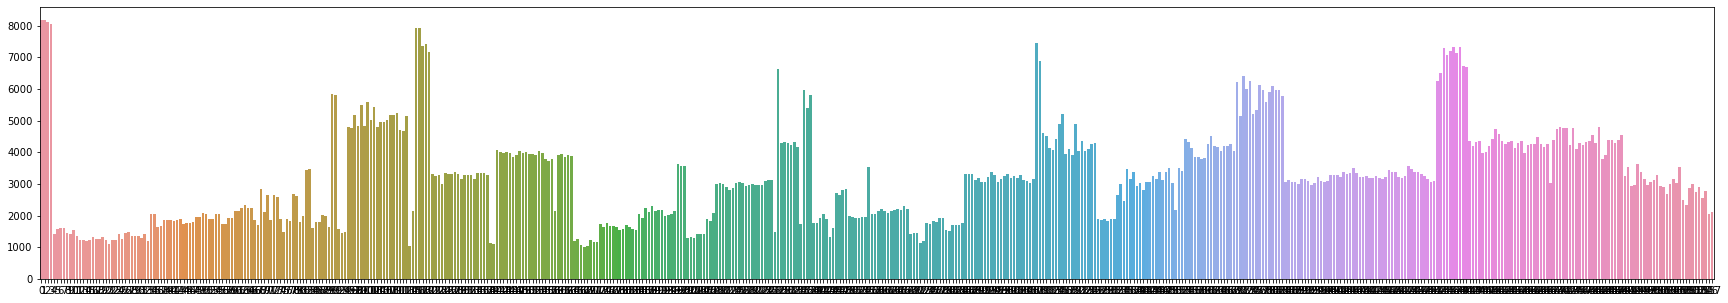

In [18]:
# Protein identification landscape
plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf))), y=nsaf.notna().sum(axis=1))

1618


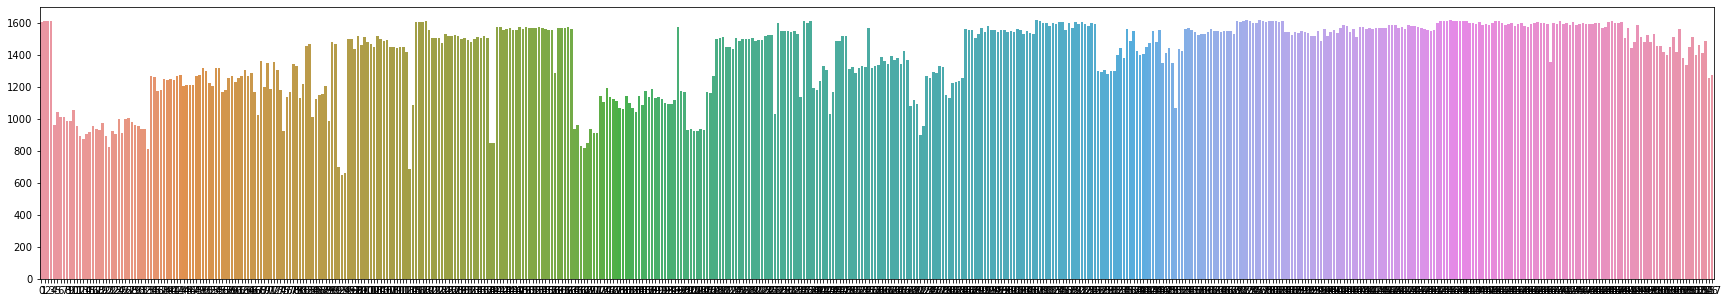

In [22]:
reoccuring, deleted = AAF._identify_global_reoccured_proteins(nsaf.fillna(0), .7)
nsaf_reoccur = nsaf.loc[:,reoccuring]
print(len(reoccuring))

plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf_reoccur))), y=nsaf_reoccur.notna().sum(axis=1))

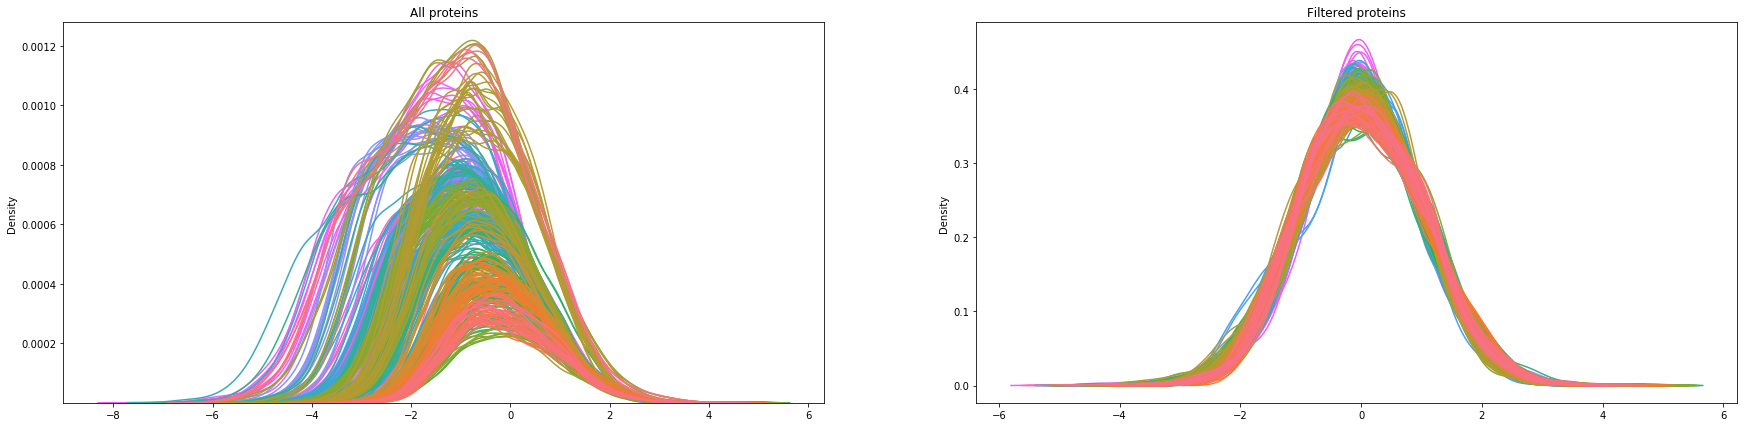

In [23]:
def calc_median(row):
    values = row[row!=0]
    return np.median(values)

# Log2 normalize
log_nsaf = np.log2(nsaf)

# Find reoccuring prots
reoccuring, deleted = AAF._identify_global_reoccured_proteins(nsaf.fillna(0), .7)
log_nsaf_reoccur = log_nsaf.loc[:,reoccuring]

# Define median and std
med_std = pd.DataFrame()
med_std['median'] = log_nsaf_reoccur.fillna(0).apply(lambda x: calc_median(x), axis =1)
med_std['std'] = log_nsaf_reoccur.apply(lambda x: np.std(x), axis =1)

# Scale samples
def scale_sample(row):
    median, std = med_std.loc[row.name,:]
    return (row-median)/std

scaled_nsaf = log_nsaf.apply(lambda x: scale_sample(x), axis = 1)
scaled_nsaf_reoccur = scaled_nsaf.loc[:,reoccuring]

# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=scaled_nsaf.transpose(), legend = False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=scaled_nsaf_reoccur.transpose(), legend = False, common_norm=False, ax =ax[1])

In [25]:
scaled_nsaf.to_csv("../PEMatrix/norm_NSAF_data2.csv")